In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dtaidistance import dtw, dtw_c, dtw_ndim
from numpy.random import choice, shuffle
from torch import nn

In [2]:
%load_ext autoreload
%autoreload 1

from preprocessing import *
from models import Encoder, Decoder, Sequence2Sequence

%aimport preprocessing
%aimport models

# Example of multidimensional time-series

In [3]:
# !mkdir -p data
# !wget https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/UCRArchive_2018.zip ../data
# !unzip data/UCRArchive_2018.zip -d ../data

In [4]:
data_path = "../data/UCRArchive_2018/Earthquakes/Earthquakes_TRAIN.tsv"

In [5]:
data = pd.read_csv(data_path, header=None, delimiter="\t").values

# to remove Nan (only first columns)
data = data[:, ~np.isnan(data).any(0)]

X = data[:, 1:]
y = data[:, 0].astype(np.short)

In [6]:
data

array([[ 1.        , -0.51800895, -0.51800895, ..., -0.51800895,
         1.4658264 , -0.51800895],
       [ 0.        ,  1.9437326 , -0.35311462, ..., -0.35311462,
        -0.35311462, -0.35311462],
       [ 0.        ,  2.6385165 , -0.31610235, ..., -0.31610235,
        -0.31610235, -0.31610235],
       ...,
       [ 0.        , -0.26465174, -0.26465174, ..., -0.26465174,
        -0.26465174, -0.26465174],
       [ 0.        , -0.49082731, -0.49082731, ..., -0.49082731,
        -0.49082731, -0.49082731],
       [ 0.        , -0.4839215 , -0.4839215 , ..., -0.4839215 ,
        -0.4839215 , -0.4839215 ]])

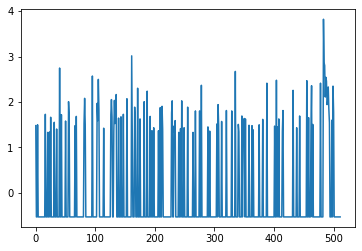

In [7]:
plt.plot(X[9])

# Accelerometer dataset 

- 1: Working at Computer
- 2: Standing Up, Walking and Going up\down stairs
- 3: Standing
- 4: Walking
- 5: Going Up\Down Stairs
- 6: Walking and Talking with Someone
- 7: Talking while Standing

In [8]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip -O ../data/Accelerometer.zip
# ! unzip ../data/Accelerometer.zip -d ./data

In [9]:
data_path = "../data/Activity Recognition from Single Chest-Mounted Accelerometer/1.csv"
CHANNELS = ['0', '1', '2']
LABELS = [1, 4, 5, 6]
LENGTH = 50
start_ident = 200

In [10]:
data = pd.read_csv(data_path,
                   names=['0', '1', '2', "labels"],
                   index_col=0,
                   dtype=np.float)

In [11]:
np.random.seed(0)

dataset = {}
for label in LABELS:
    X = get_class_timeseries(label, data, start_ident)
    X = np.linalg.norm(X, axis=1)[np.newaxis].T
    dataset[label] = slice_timeseries(X, LENGTH, count=45)
    

X = [x for _, ts in dataset.items() for x in ts]
y = [np.repeat(label, ts.shape[0]) for label, ts in dataset.items() for x in ts]
X = np.hstack(X).T
y = np.hstack(y).T

idxs = list(range(X.shape[0]))
shuffle(idxs)

X = X[idxs]
y = y[idxs]

In [78]:
w = 4
k = 4

input_dim = 2*k
hidden_dim = 5
n_layers = 3
batch_size = 10

In [80]:
sequences = [split_to_sequence(x, k, w) for x in X[choice(len(X), batch_size)]]

Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.
Last 2 points are not considered.


In [81]:
inp = torch.tensor(sequences, dtype=torch.float).permute(1, 0, 2)
inp.shape

torch.Size([11, 10, 8])

In [82]:
lstm = nn.LSTM(input_dim, hidden_dim, n_layers)

In [83]:
he = torch.randn(n_layers, batch_size, hidden_dim, dtype=torch.float)
ce = torch.randn(n_layers, batch_size, hidden_dim, dtype=torch.float)

hd = torch.randn(n_layers, batch_size, input_dim, dtype=torch.float)
cd = torch.randn(n_layers, batch_size, input_dim, dtype=torch.float)

In [84]:
out, (h_n, c_n) = lstm(inp, )

In [85]:
from models import Encoder, Decoder, Sequence2Sequence
enc = Encoder(input_dim, hidden_dim, 1, 1, 3)
dec = Decoder(hidden_dim, input_dim, 1, 1, 3)

In [86]:
model = Sequence2Sequence(enc, dec)

In [87]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

In [88]:
N_STEP = 10

def train(model, batch):
    for step in range(N_STEP):
        out = model(batch)
        loss = loss_fn(batch, out)
        
        if i % 5 == 0:
            print("Loss:", loss)
        
        loss.backward()
        optim.step()

In [89]:
train(model, inp)

TypeError: forward() missing 4 required positional arguments: 'h_enc', 'c_enc', 'h_dec', and 'c_dec'